In [ ]:
import os
exists = os.path.isfile('readtria.py')
if not(exists):
    print("Downloading meshes ...")
    !git clone https://github.com/dpeschka/NumFluids.git
    !cp -r NumFluids/notebook/meshes .
    !cp NumFluids/notebook/readtria.py .
else:
    print("All is set.")

Below we solve PDEs using the finite element method. For the moment we concentrate on the problem of finding $u\in V$ such that

$$
\int_\Omega a(x)\nabla u(x)\cdot\nabla \varphi(x)\,\mathrm{d}x=\int f(x)\varphi(x)\,\mathrm{d}x,
$$

for all $\varphi\in V$ for some appropriate function space $V=H^1_0(\Omega)$. Here, the functions $a,f$ are given and satisfy some further conditions, i.e. $a$ is  positive and measureable and $f\in L^2(\Omega)$. 



This requires the understanding of some steps such as:

0. How does the weak formulation relate to the original PDE?

1. Meshing and distribution/enumeration of degrees of freedoms (DOFS) via the arrays `e1` in 1D or `e2` in 2D.

2. Transforming of integral to reference domain, i.e.

$$
\int_\Omega f(x)\mathrm{d}x = \int_{\bar{\Omega}} f(\psi(y))|{\det F(y)}|\mathrm{d}y
$$

where $F=\nabla \psi(y)$ and $\psi:\bar{\Omega}\to\Omega$.

3. Computation of mass and stiffness matrix $M$ and $S$

$$
M_{ij}=\int_\Omega \varphi_i(x)\varphi_j(x)\mathrm{d}x
$$
$$
S_{ij}=\int_\Omega \nabla\varphi_i(x)\cdot\nabla\varphi_j(x)\mathrm{d}x
$$

but usually only on a local triangle $\Omega=\cup_m T_m$, e.g.

$$
M^m_{ij}=\int_{T_m} \varphi_i(x)\varphi_j(x)\mathrm{d}x = \int_{T^\mathrm{ref}} \hat{\varphi}_k(y)\hat{\varphi}_l(y)|{\det F_m}|\mathrm{d}y.
$$

where the mapping of indices $(k,l)\mapsto (i,j)$ is supposedly known for a given triangle $T_m$.


4. Then the matrix assembly constitutes the collection of all terms that contribute to the specific matrix $M$

$$
M_{ij} = \sum_{m} M^m_{ij} = \sum_m \int_{T^\mathrm{ref}} \hat{\varphi}_k(y)\hat{\varphi}_l(y)|{\det F_m}|\mathrm{d}y.
$$

**Tasks/questions:**

1. Modify the problem, such that you have different values of $a$ in different parts of the domain. In particular try 

$$
a(x)=\begin{cases} a_0 & x<1/2 \\ a_1 & \text{otherwise} \end{cases},
$$

with different values of $a_0,a_1$. What condition do solutions satisfy at $x=1/2$?

2. Use Neumann boundary conditions on one part of the boundary, i.e. $u'(1)=0$. 

Hint: Neumann boundary conditions are natural boundary conditions and therefore can be inforced by 'doing nothing' to the original problem.

3. Can you impose inhomogeneous Neumann boundary conditions, i.e. $u'(1)=g_1$ for a given $g_1\in\mathbb{R}$?

4. Why can't you solve the problem with Neumann boundary conditions on both sides?

Hint: Solvability conditions.

5. Change the problem from

$$
-u''(x)=f(x) \qquad\text{to}\qquad -u''(x)+u(x)=f(x)
$$

with the same (Dirichlet) boundary conditions.

# Lecture 04: Finite Element Method 1D

In [ ]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def generate_elements1D(x):
    npo = x.size                            # number of points
    ne = npo-1                              # number of elements
    a = np.arange(0, npo-1).reshape((-1, 1))
    b = np.arange(1, npo).reshape((-1, 1))
    e1 = np.concatenate((a, b), axis=1)      # element specificiation
    return ne, npo, e1

def generate_transformation1D(k, e1, x):
    dx = x[e1[k, 1]]-x[e1[k, 0]]            # length of k-th interval
    Fdet = dx                             # determinant
    Finv = 1/dx                             # inverse transformation
    return Fdet, Finv

def local_mass1D(Fdet):
    return np.array(((1./3, 1./6), (1./6, 1./3)))*Fdet

def local_stiff1D(Fdet, Finv):
    G = np.array(Finv)
    sloc = np.zeros((2, 2))
    sloc[0, 0] = G.T.dot(G.dot(Fdet))
    sloc[0, 1] = - G.T.dot(G.dot(Fdet))
    sloc[1, 0] = sloc[0, 1]
    sloc[1, 1] = sloc[0, 0]
    return sloc

# FEM MATLAB sample code
N     = 64                           # 1D: number of points
nphi  =  2                           # P1: 2 local basis functions
x     = np.linspace(0, 1, N)         # array of points

ne, npo, e1 = generate_elements1D(x) # generate mesh
localtoglobal1DP1 = e1               # could it be this simple? why?

# assemble matrices
ii = np.zeros((ne, nphi**2))         # sparse i-index
jj = np.zeros((ne, nphi**2))         # sparse j-index
aa = np.zeros((ne, nphi**2))         # entry of Galerkin matrix
bb = np.zeros((ne, nphi**2))         # entry in mass-matrix (to build rhs)

for k in np.arange(0, ne):
    Fdet, Finv = generate_transformation1D(k, e1, x)  # compute trafo
    
    # build local matrices (mass, stiffness, ...)
    sloc = local_stiff1D(Fdet, Finv)  # element stiffness matrix
    mloc = local_mass1D(Fdet)         # element mass matrix
    
    # compute i,j indices of the global matrix
    dofs = localtoglobal1DP1[k, :]
    ii[k, :] = [dofs[0], dofs[1], dofs[0], dofs[1]]  # local-to-global
    jj[k, :] = [dofs[0], dofs[0], dofs[1], dofs[1]]  # local-to-global
    
    # compute a(i,j) values of the global matrix      
    aa[k, :] = sloc.flatten(order="F")
    bb[k, :] = mloc.flatten(order="F")

A = sparse.csr_matrix((aa.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(N, N))
M = sparse.csr_matrix((bb.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(N, N))

# build rhs and take into account Dirichlet bcs, solve, plot
rhs = M.dot(np.ones(N))
u = np.zeros(N)
u[1:-1] = spsolve(A[1:-1, 1:-1], rhs[1:-1])

# plot solution
plt.figure()
plt.plot(x, u,x, x*(1-x)/2, 'r.')
plt.show()

# Lecture 04: Finite Element Method 2D

Most of the questions concerning modification of the problem from the 1D FEM problem also apply to the 2D problem. So please try 

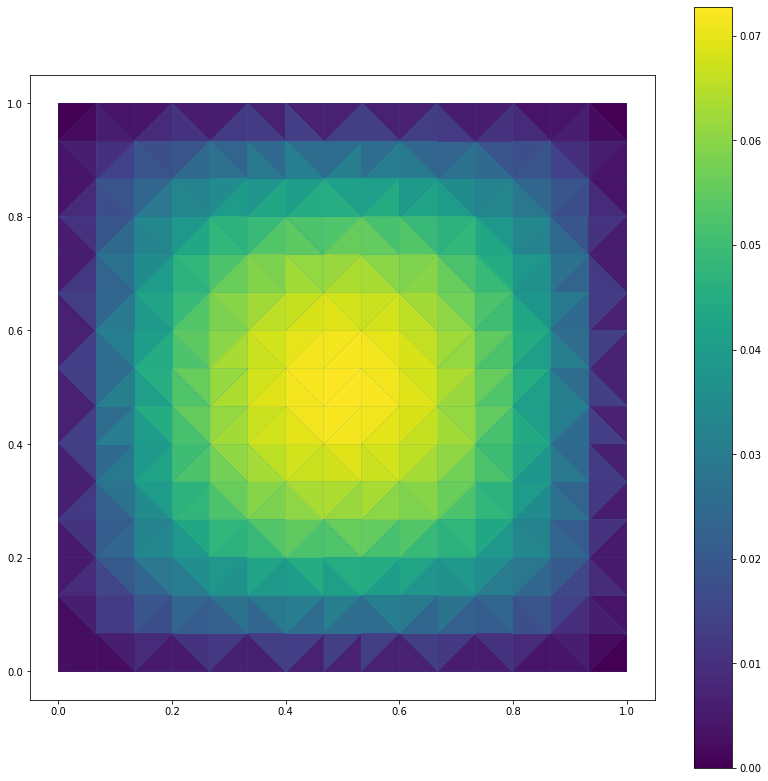

In [47]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from readtria import readtria

def square_mesh(L=1.0,k=16):
    h = L/k
    xh, yh = np.meshgrid(np.linspace(0,L,k), np.linspace(0,L,k)) 
    xh     = xh.flatten()
    yh     = yh.flatten()
    points = np.array([xh,yh]).T
    tri    = Delaunay(points)
    e2     = tri.simplices
    
    nelement = np.size(e2,0)
    npoint   = np.size(xh,0)
    
    # sel      = 
    idp      = np.zeros(npoint)
    idp[(xh<h/2)|(yh<h/2)|(xh>(L-h/2))|(yh>(L-h/2))] = 1
    ide      = []

    return xh,yh,npoint,nelement,e2,idp,ide

def generate_transformation2D(k, e2, x, y):
    dx1 = x[e2[k, 1]]-x[e2[k, 0]]
    dy1 = y[e2[k, 1]]-y[e2[k, 0]]

    dx2 = x[e2[k, 2]]-x[e2[k, 0]]
    dy2 = y[e2[k, 2]]-y[e2[k, 0]]

    # determinant on each triangle
    Fdet = dx1*dy2 - dx2*dy1

    # transformation Jacobian on each triangle
    Finv = np.zeros((2, 2))
    Finv[0, 0] =  dy2 / Fdet
    Finv[0, 1] = -dx2 / Fdet
    Finv[1, 0] = -dy1 / Fdet
    Finv[1, 1] =  dx1 / Fdet

    return Fdet, Finv


def local_stiff2D(Fdet, Finv):
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]])
    dphi    = gradphi.dot(Finv)
    S = 1/2*(dphi[:, 0].reshape(-1, 1).dot(dphi[:, 0].reshape(1, -1)) +
             dphi[:, 1].reshape(-1, 1).dot(dphi[:, 1].reshape(1, -1)))*Fdet
    return S

def local_mass2D(Fdet):
    return Fdet*np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12

# FEM Python sample code
# x, y, npo, ne, e2, idp, ide = readtria('./meshes/house.1')  # read mesh from file
#x, y, npo, ne, e2, idp, ide = readtria('./meshes/cheese')  # read mesh from file
x, y, npo, ne, e2, idp, ide = square_mesh()  # read mesh from file

localtoglobal2DP1           = e2                  # could it be this simple? why?

# select points without Dirichlet bc
it = np.logical_not(idp == 1)
nphi = 3

# build matrices
ii = np.zeros((ne, nphi**2))  # sparse i-index
jj = np.zeros((ne, nphi**2))  # sparse j-index
aa = np.zeros((ne, nphi**2))  # entry of Galerkin matrix
bb = np.zeros((ne, nphi**2))  # entry in mass-matrix (to build rhs)

for k in np.arange(0, ne):
    Fdet, Finv = generate_transformation2D(k, e2, x, y)  # compute trafo
    #
    # build local matrices (mass, stiffness, ...)
    sloc = local_stiff2D(Fdet, Finv)  # element stiffness matrix
    mloc = local_mass2D(Fdet)       # element mass matrix
    #
    # compute i,j indices of the global matrix
    dofs = localtoglobal2DP1[k, :]
    ii[k, :] = dofs[[0, 1, 2, 0, 1, 2, 0, 1, 2]]  # local-to-global
    jj[k, :] = dofs[[0, 0, 0, 1, 1, 1, 2, 2, 2]]  # local-to-global
    #
    # compute a(i,j) values of the global matrix
    aa[k, :] = sloc.flatten(order="F")
    bb[k, :] = mloc.flatten(order="F")

# create sparse matrices
A = sparse.csr_matrix((aa.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(npo, npo))
M = sparse.csr_matrix((bb.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(npo, npo))

# build rhs and take into account Dirichlet bcs, solve, plot
rhs = M*np.ones(npo)
u = np.zeros(npo)
u[it] = spsolve(A[np.ix_(it, it)], rhs[it])

# plotting
fig, ax = plt.subplots(figsize=(14,14))
ax.set_aspect('equal')
c = plt.tripcolor(x,y,u,triangles=e2)
plt.triplot(x,y,triangles=e2,linewidth=0.1)
fig.colorbar(c)
